In [1]:
%pylab inline
import scipy.optimize
import calin.math.rng
import calin.simulation.vs_cta
import calin.simulation.vs_optics

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# DESY PSF 

From Dan Parsons using ROBAST (received on Slack in 2025). The aim of this notebook is to compare the calin "VSO" model for the MST to these results.

The relevant dataset from Dan's plot is represented by the red dashed curve, correspondng to an infinite (very distant) source focussed onto the focal plane (white target) of the MST at 1600 cm from the mirror, and digitized online with values given below.

![DESY PSF plot](desy_psf.png)

In [2]:
xdan = arange(0,4.001,0.5)
ydan = asarray([  8.62725450901803,
                  9.679358717434866,
                 12.344689378757511,
                 15.71142284569138,
                 19.358717434869735,
                 23.426853707414825,
                 27.284569138276552,
                 31.63326653306613,
                 36.052104208416836 ])

# Calin model

In [3]:
mst = calin.simulation.vs_cta.mstn1_config()
mst.mutable_focal_plane().mutable_translation().set_y(
    mst.reflector().alignment_image_plane()) # Focus at 1600 cm for source at infinity
# mst.mutable_reflector().set_facet_alignment_dispersion(0.125) # 0.025
# mst.mutable_reflector().set_facet_spot_size(0.5 * 1.4) # 2.2

# mst.mutable_reflector().set_facet_focal_length(0.5 * 3216.6)
# mst.mutable_reflector().set_facet_focal_length_dispersion(0.5 * 7.8)
# mst.mutable_reflector().set_facet_spot_size(0.5 * 1.4)
# mst.mutable_reflector().set_facet_spot_size_dispersion(0.5 * 0.16)
# mst.mutable_reflector().set_facet_alignment_dispersion(0.24)

In [4]:
print(mst.SerializeAsJSON(True))

{
 "arrayOrigin": {
  "latitude": 28.761470126836642,
  "longitude": -17.891950641997617,
  "elevation": 218641.5789473684,
  "datum": ""
 },
 "prescribedArrayLayout": {
  "scopePositions": [
   {
    "x": -21656.311570678496,
    "y": 10401.055648736656,
    "z": 216740
   }
  ]
 },
 "reflectorFrame": {
  "fpOffset": 0,
  "alphaX": 0,
  "alphaY": 0,
  "translation": {
   "x": 0,
   "y": -175,
   "z": 0
  },
  "opticAxisRotation": -90,
  "azimuthElevationAxesSeparation": 160
 },
 "reflector": {
  "curvatureRadius": 1920,
  "aperture": 1245,
  "psfAlign": {
   "objectPlane": "Infinity",
   "imagePtTheta": 0,
   "imagePtPhi": 0
  },
  "alignmentImagePlane": 1600,
  "facetAlignmentDispersion": 0.24,
  "facetNumHexRings": 5,
  "facetSpacing": 124,
  "facetSize": 120,
  "facetGridShiftX": 0,
  "facetGridShiftZ": 0,
  "facetFocalLength": 1608.3,
  "facetFocalLengthDispersion": 3.9,
  "facetSpotSizeProbability": 0.8,
  "facetSpotSize": 0.7,
  "facetSpotSizeDispersion": 0.08,
  "facetPosTangen

In [5]:
rng = calin.math.rng.RNG()

In [6]:
def r80(x,y):
    def f(x0):
        r2 = (x-x0)**2 + y**2
        r = sqrt(percentile(r2,80))
        return r
    x0 = mean(x)
    res = scipy.optimize.minimize_scalar(f, bounds=[x0-10,x0+10])
    return res

In [7]:
yvso = []
for theta in xdan:
    all_x = asarray([])
    all_y = asarray([])
    for i in range(100):
        cta = calin.simulation.vs_optics.VSOArray()
        cta.generateFromArrayParameters(mst, rng)
        tracer = calin.simulation.vs_optics.VCLScopeRayTracerDouble512(cta.telescope(0))
        nsim,x,y,t=tracer.psf(10000,theta,0)
        all_x = append(all_x, x)
        all_y = append(all_y, y)
    res = r80(all_x,all_y)
    yvso.append(res.fun)
yvso = asarray(yvso)

(np.float64(-130.28121471528786),
 np.float64(-109.1813632047483),
 np.float64(-7.562293880621962),
 np.float64(13.537557629917604))

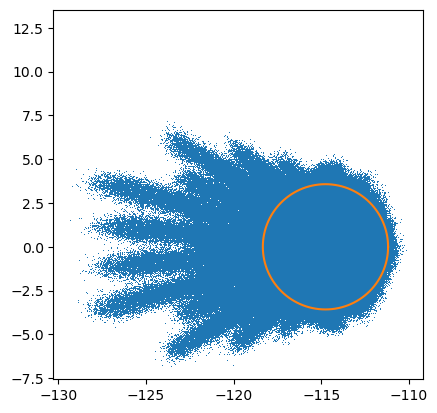

In [8]:
tt = arange(360.01)
xx = res.fun*cos(tt/180*pi) + res.x
yy = res.fun*sin(tt/180*pi)
plot(all_x,all_y,',')
plot(xx,yy,'-')
axis('square')

Text(0, 0.5, 'PSF R80 [mm]')

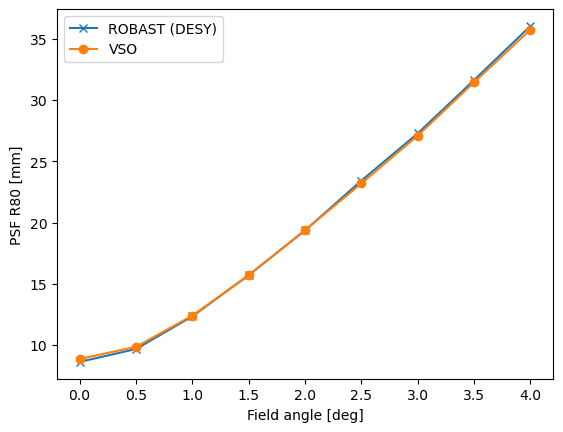

In [9]:
plot(xdan,ydan,'x-',label='ROBAST (DESY)')
plot(xdan,yvso*10.0,'o-',label='VSO')
legend()
xlabel('Field angle [deg]')
ylabel('PSF R80 [mm]')